# Depth analysis
 The goal of this study is to give a measure of the depth of the "memory" of the model, to understand how much token are necessary for the model to forget one of the Principal older tokens.

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import torch.nn.functional as F

# Upload tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()


/home/riccorte/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-19 11:37:31.510881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747647451.807746    6634 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747647451.876880    6634 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-19 11:37:32.589484: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operat

floor: 0.0764
bed: 0.0653
couch: 0.0541
ground: 0.0521
edge: 0.0478
bench: 0.0316
table: 0.0315
sofa: 0.0288
other: 0.0199
back: 0.0190


In [29]:

input_text = "Lorenzo , my best friend, is the best player in the world. He is a great sportmanship because once he killed a guy, this guy was really handome and tall. He once invited me to his house and showed me his room which was filled with pizzas and bananas. The name of my best friend is:"
input_text = "Albert"
inputs = tokenizer(input_text, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

#  Takes the logit of the last token
last_token_logits = logits[0, -1, :]
probs = F.softmax(last_token_logits, dim=-1)

# Top 10 token predicted
top_k = torch.topk(probs, k=10)
for i in range(10):
    token = tokenizer.decode(top_k.indices[i])
    prob = top_k.values[i].item()
    print(f"{token.strip()}: [{prob:.4f}]")


,: [0.0637]
.: [0.0496]
: [0.0278]
and: [0.0239]
's: [0.0220]
-: [0.0168]
in: [0.0130]
is: [0.0107]
of: [0.0102]
to: [0.0095]


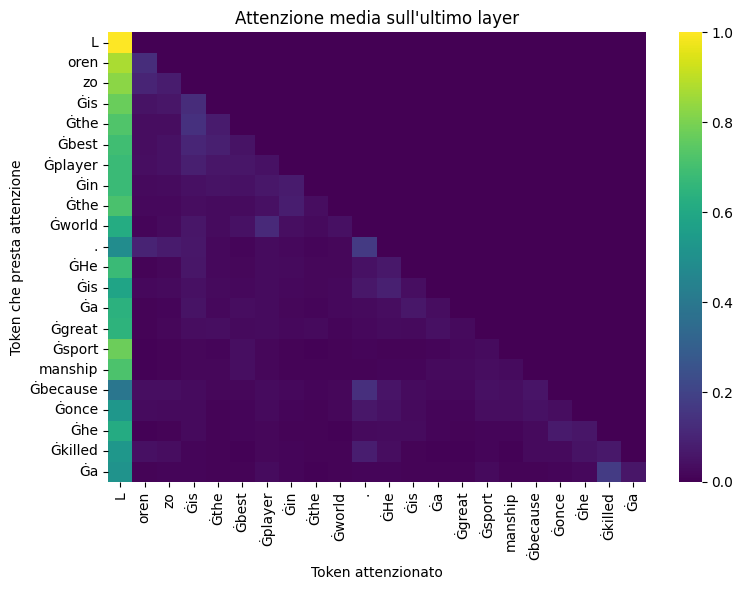

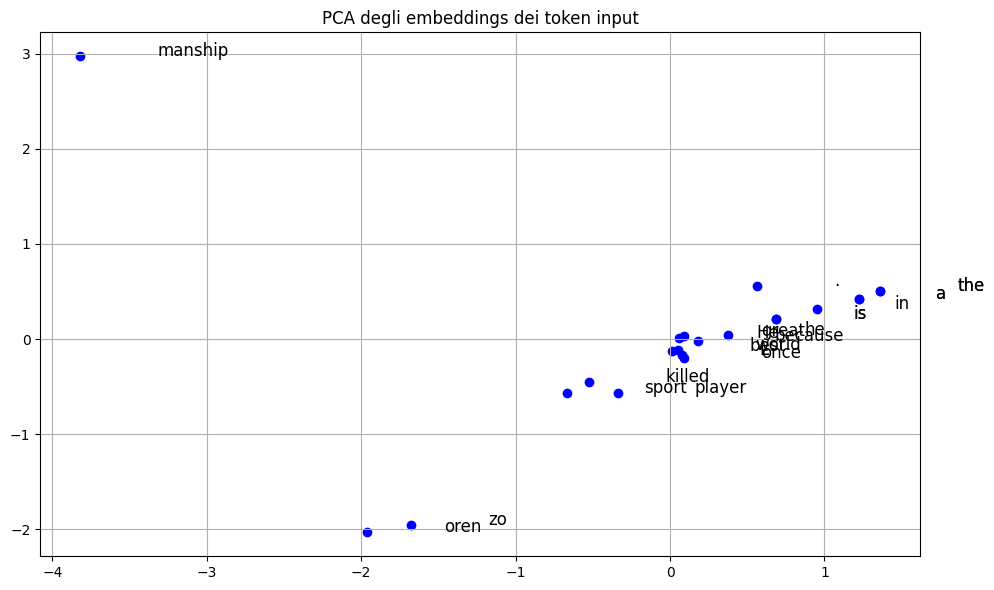

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np

# Richiedi anche le matrici di attenzione
outputs = model(**inputs, output_attentions=True)
attentions = outputs.attentions  # tuple (n_layers,) of (batch, heads, seq_len, seq_len)

# Prendi attenzione dell'ultimo layer e media su tutte le teste
attn_last_layer = attentions[-1][0]  # shape: (heads, seq_len, seq_len)
attn_avg = attn_last_layer.mean(dim=0)  # (seq_len, seq_len)

# Visualizza la matrice di attenzione
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
plt.figure(figsize=(8, 6))
sns.heatmap(attn_avg.detach().numpy(), xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title("Attenzione media sull'ultimo layer")
plt.xlabel("Token attenzionato")
plt.ylabel("Token che presta attenzione")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# PCA sugli embedding dei token
embedding_layer = model.transformer.wte
token_ids = inputs["input_ids"][0]
embeddings = embedding_layer(token_ids).detach().numpy()

# Riduzione dimensionale
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

# Visualizza proiezione PCA
plt.figure(figsize=(10, 6))
for i, token_id in enumerate(token_ids):
    token = tokenizer.decode([token_id])
    x, y = reduced[i]
    plt.scatter(x, y, color="blue")
    plt.text(x + 0.5, y, token.strip(), fontsize=12)
plt.title("PCA degli embeddings dei token input")
plt.grid(True)
plt.tight_layout()
plt.show()


Token ID: 43, Token: L
Token ID: 29578, Token: oren
Token ID: 10872, Token: zo
Token ID: 318, Token: is
Token ID: 262, Token: the
Token ID: 1266, Token: best
Token ID: 2137, Token: player
Token ID: 287, Token: in
Token ID: 262, Token: the
Token ID: 995, Token: world
Token ID: 13, Token: .
Token ID: 679, Token: He
Token ID: 318, Token: is
Token ID: 257, Token: a
Token ID: 1049, Token: great
Token ID: 6332, Token: sport
Token ID: 25428, Token: manship
Token ID: 780, Token: because
Token ID: 1752, Token: once
Token ID: 339, Token: he
Token ID: 2923, Token: killed
Token ID: 257, Token: a


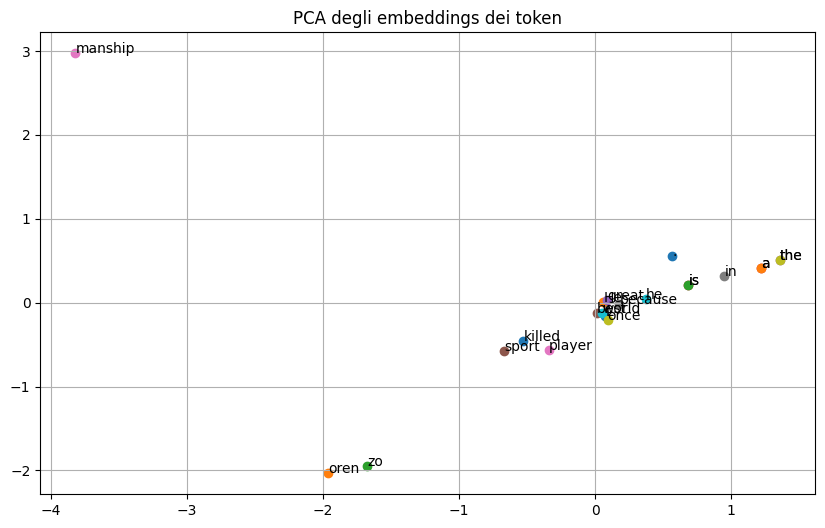

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Prendi gli embedding dei token input
embedding_layer = model.transformer.wte
token_ids = inputs["input_ids"][0]
embeddings = embedding_layer(token_ids).detach().numpy()

# print the token ids and their corresponding embeddings
for token_id, embedding in zip(token_ids, embeddings):
    token = tokenizer.decode([token_id])
    print(f"Token ID: {token_id.item()}, Token: {token.strip()}")
    
# PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

# Visualizza
plt.figure(figsize=(10, 6))
for i, word_id in enumerate(token_ids):
    token = tokenizer.decode([word_id])
    plt.scatter(reduced[i, 0], reduced[i, 1])
    plt.text(reduced[i, 0], reduced[i, 1], token.strip())
plt.title("PCA degli embeddings dei token")
plt.grid()
plt.show()


### Approccio completo

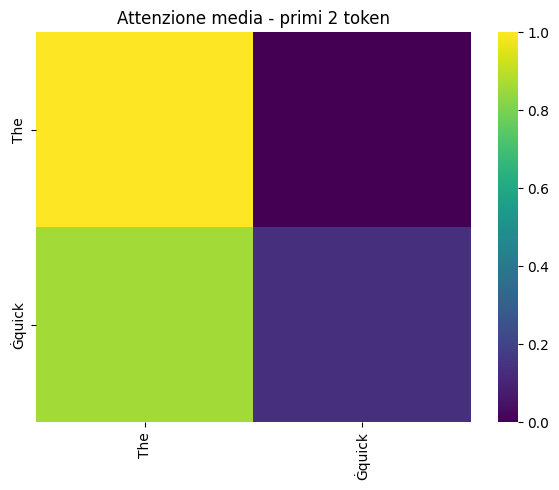

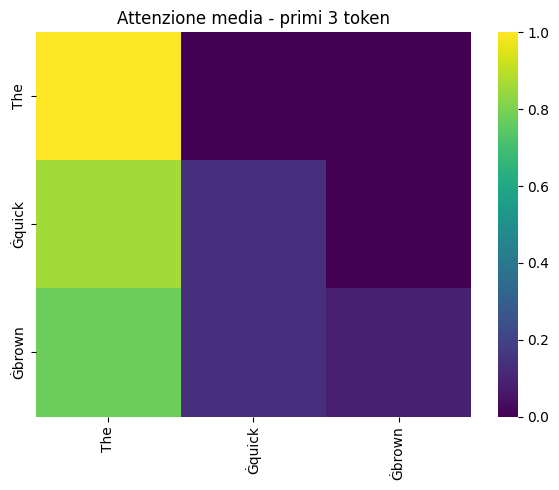

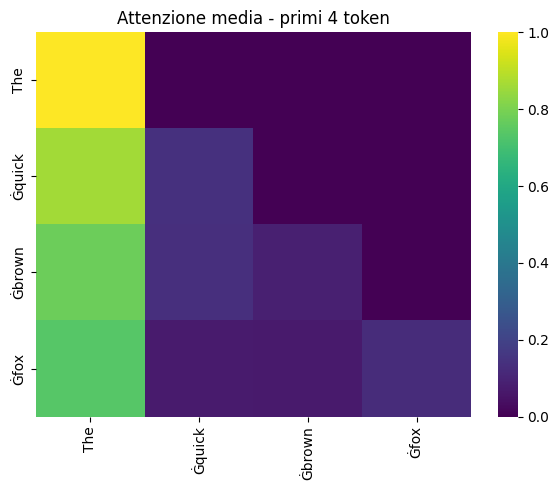

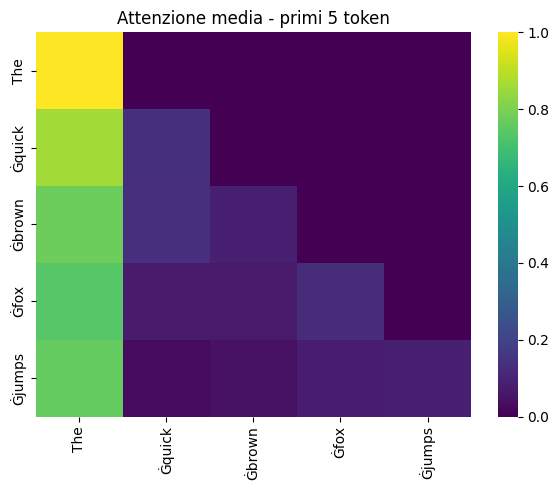

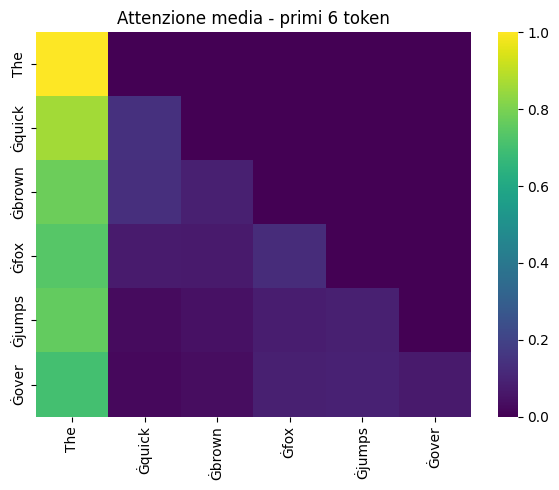

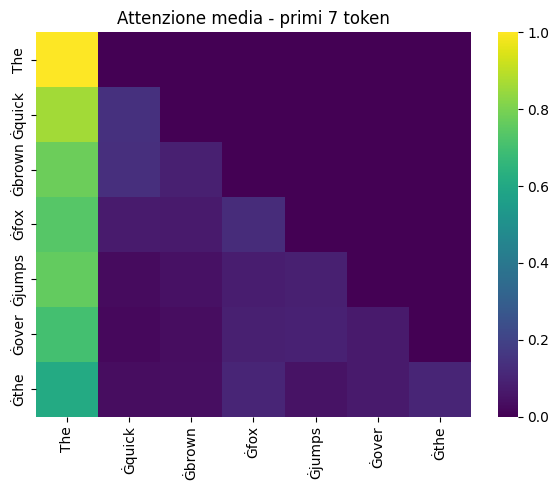

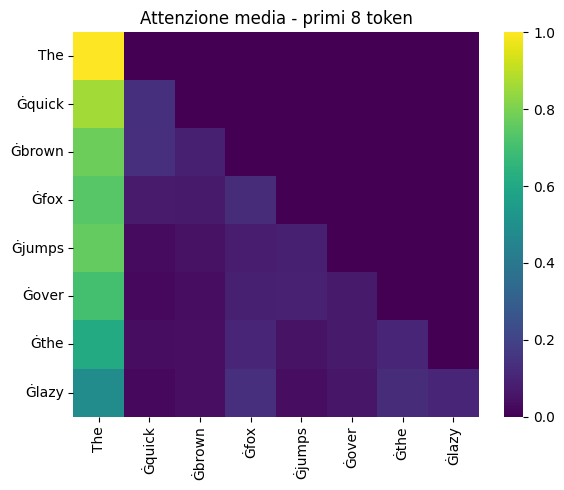

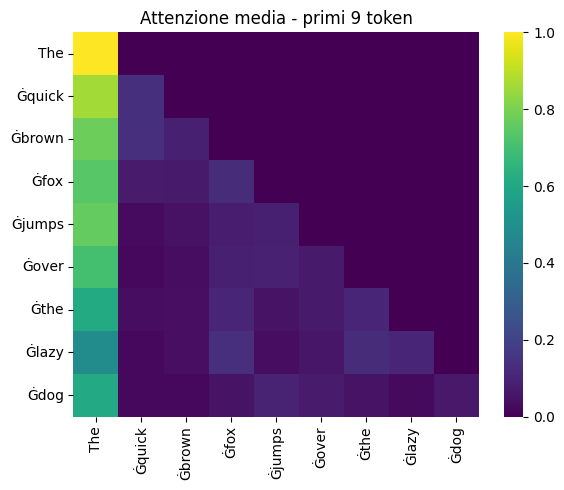

Rimozione del token 'The': KL Divergence = 0.0000
Rimozione del token 'quick': KL Divergence = 0.0000
Rimozione del token 'brown': KL Divergence = 0.0000
Rimozione del token 'fox': KL Divergence = 0.0000
Rimozione del token 'jumps': KL Divergence = 0.0000
Rimozione del token 'over': KL Divergence = 0.0000
Rimozione del token 'the': KL Divergence = 0.0000
Rimozione del token 'lazy': KL Divergence = 0.0000
Rimozione del token 'dog': KL Divergence = 0.0001


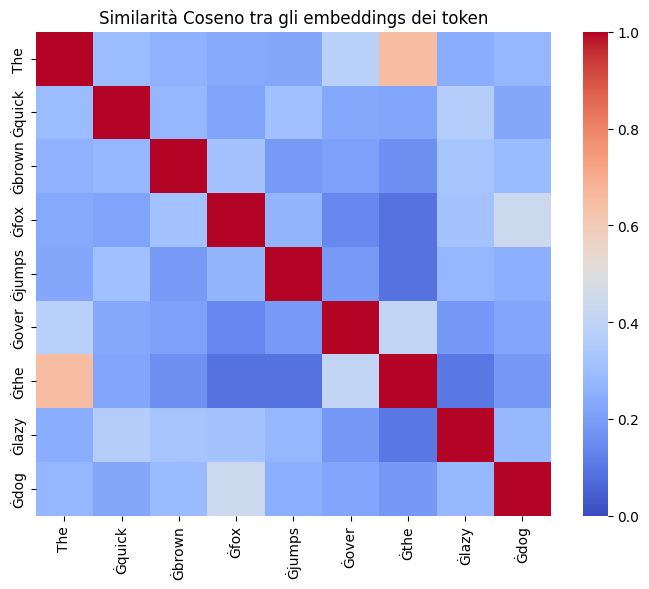

In [ ]:
# Analisi Avanzate dell'Attenzione di GPT-2

from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Carica modello e tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()

# Funzione per ottenere output e attenzione
def get_outputs(text):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    return inputs, outputs

# Funzione: mostra evoluzione attenzione

def plot_attention_evolution(base_text, max_steps=10):
    for i in range(2, min(len(base_text.split()), max_steps)+1):
        partial = " ".join(base_text.split()[:i])
        inputs, outputs = get_outputs(partial)
        tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
        attn_avg = outputs.attentions[-1][0].mean(dim=0).numpy()

        plt.figure(figsize=(6, 5))
        sns.heatmap(attn_avg, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
        plt.title(f"Attenzione media - primi {i} token")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

# Funzione: impatto della rimozione di un token

def token_removal_impact(text):
    inputs, outputs = get_outputs(text)
    logits = outputs.logits[0, -1, :]
    probs_orig = F.softmax(logits, dim=-1)

    words = text.split()
    for i in range(len(words)):
        modified_text = " ".join(words[:i] + words[i+1:])
        _, mod_outputs = get_outputs(modified_text)
        mod_logits = mod_outputs.logits[0, -1, :]
        probs_mod = F.softmax(mod_logits, dim=-1)
        kl_div = F.kl_div(probs_mod.log(), probs_orig, reduction="batchmean")
        print(f"Rimozione del token '{words[i]}': KL Divergence = {kl_div.item():.4f}")

# Funzione: similarità embedding token

def embedding_similarity(text):
    inputs = tokenizer(text, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    embedding_layer = model.transformer.wte
    embeddings = embedding_layer(inputs["input_ids"][0]).detach().numpy()

    sim_matrix = cosine_similarity(embeddings)

    plt.figure(figsize=(7, 6))
    sns.heatmap(sim_matrix, xticklabels=tokens, yticklabels=tokens, cmap="coolwarm", vmin=0, vmax=1)
    plt.title("Similarità Coseno tra gli embeddings dei token")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# ESEMPIO DI USO
text = "The quick brown fox jumps over the lazy dog"
plot_attention_evolution(text)
token_removal_impact(text)
embedding_similarity(text)
